<a href="https://colab.research.google.com/github/mcstllns/DeepLearning/blob/main/P07c_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo con una LSTM

Construímos con Keras una red recurrente para predecir las manchas solares (sunspots), como parece que hay una temporalidad se utiliza una rede recurrente.

In [1]:
# Supress info messages
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Importamos las librerías necesarias

from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [2]:
# Importamos los datos desde un github

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
df = read_csv(url, usecols=[1], engine='python')


In [3]:
# Se convierten en flotantes
data = np.array(df.values.astype('float32'))

# Normalizamos (0,1)
# scaler = MinMaxScaler(feature_range=(0, 1))
data = MinMaxScaler(feature_range=(0, 1)).fit_transform(data).flatten()

# Se crea train y test
split = int(len(data)*0.8)
train_data = data[range(split)]
test_data = data[split:]


In [4]:

# Hay que generar la estructura de casos x tiemstapms x vars
# En este caso solo tenemos una var, la secuencia de manchas solares
# Esta es la parte mas compleja, se define una funcion que va a partir toda la secuencia en cadenas de t timestamps
# pe: 1, 2, 3, 4, 5, 6, 7 y t = 2

#     X: 1, 2  Y: 3
#        3, 4     5
#        5, 6     7

def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_stamps = 12

trainX, trainY = get_XY(train_data, time_stamps)
testX, testY = get_XY(test_data, time_stamps)


In [5]:
print(trainX.shape) # vemos la estructura tridimensional de X
print(trainX)
print(trainY.shape) # Y solo tiene una estructura unidimensional
print(trainY)

(187, 12, 1)
[[[0.22852638]
  [0.24665089]
  [0.2758077 ]
  ...
  [0.29747832]
  [0.6249015 ]
  [0.33569738]]

 [[0.28881007]
  [0.29905435]
  [0.3514578 ]
  ...
  [0.2588652 ]
  [0.24940896]
  [0.2970843 ]]

 [[0.2758077 ]
  [0.1713948 ]
  [0.17848699]
  ...
  [0.09141055]
  [0.11229314]
  [0.17336485]]

 ...

 [[0.04846336]
  [0.08747045]
  [0.03979511]
  ...
  [0.01182033]
  [0.00236407]
  [0.00118203]]

 [[0.01339637]
  [0.03073286]
  [0.01694247]
  ...
  [0.02245863]
  [0.03427896]
  [0.06067769]]

 [[0.07446808]
  [0.08077226]
  [0.09101655]
  ...
  [0.20961386]
  [0.25295505]
  [0.24231677]]]
(187,)
[0.28881007 0.2758077  0.13790385 0.17336485 0.         0.04018912
 0.04925138 0.05555555 0.14814813 0.19030732 0.2651694  0.2758077
 0.17257681 0.22261623 0.23522457 0.09456264 0.04728132 0.10795902
 0.2107959  0.29117414 0.40977144 0.14184396 0.3975571  0.21513
 0.18439715 0.01733648 0.08550039 0.17730495 0.6985815  0.4519306
 0.2758077  0.38888887 0.21276595 0.11032309 0.05122143 

In [6]:
# Definimos la red

hidden_units = 3 # neuronas (o unidades) del vector de memoria C
dense_units =  1 # neuronas de capa de prediccion
input_shape = (12,1) # timestamps x vars

# Se monta una red compuesta por una LSTM que se despliega 12 veces y con la activación final
# se predice el siguiente valor de sunspot

model = Sequential()
model.add(LSTM(hidden_units, input_shape=input_shape))
model.add(Dense(units=dense_units, activation="linear"))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# we can handle this <--------------------------------------------------------------
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=0)

In [8]:
print(model.evaluate(trainX, trainY))
print(model.evaluate(testX, testY))

6/6 [==============================] - 1s 4ms/step - loss: 0.0039
0.0039212629199028015
2/2 [==============================] - 0s 14ms/step - loss: 0.0068
0.006843634881079197


2/2 [==============================] - 0s 4ms/step


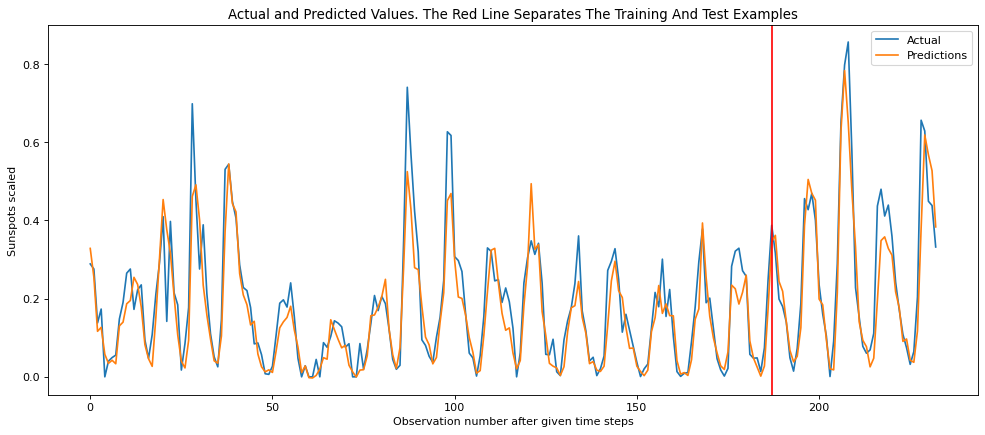

In [9]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Un grafico para el pronostico

def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

plot_result(trainY, testY, train_predict, test_predict)